## Table - Local file 



In [ ]:
import pandas as pd

# Define paths to the dataset files
dataset_paths = [
    "dataset_413.pkl",
    "dataset_415.pkl",
    "dataset_420.pkl",
    "dataset_500.pkl",  
    "dataset_504.pkl",
    "dataset_507.pkl",
    "dataset_508.pkl"
]

# Corresponding Linux kernel versions
versions = ["4.13", "4.15", "4.20", "5.0", "5.4", "5.7", "5.8"]

# List to hold computed data for the Markdown table
table_data = []

# Loop over each kernel version and corresponding dataset
for version, dataset_path in zip(versions, dataset_paths):
    # Load dataset
    df = pd.read_pickle(dataset_path)
    # Count the number of configurations (rows)
    num_configs = len(df)

    # Count the number of options (all columns)
    num_options = len(df.columns)

    # Calculate min and max size for 'vmlinux' (in MB)
    min_size = df["vmlinux"].min()/ (1024 * 1024)
    max_size = df["vmlinux"].max()/ (1024 * 1024)
    size_range = f"{min_size:.1f} - {max_size:.1f}"

    table_data.append({
        "Version": version,
        "Options": f"{num_options:,}",
        "Configurations": f"{num_configs:,}",
        "Min/Max Size (MB)": size_range
    })

markdown_table = "| Version | Options | Configurations | Min/Max Size (MB) |\n"
markdown_table += "|---------|---------|----------------|-------------------|\n"

for row in table_data:
    markdown_table += f"| {row['Version']} | {row['Options']} | {row['Configurations']} | {row['Min/Max Size (MB)']} |\n"

print(markdown_table)

## Table - OpenML

In [ ]:
import pandas as pd
import openml

# Linux kernel versions with corresponding OpenML dataset IDs
dataset_info = [
    ("4.13", 46759),
    ("4.15", 46739),
    ("4.20", 46740),
    ("5.0", 46741),
    ("5.4", 46742),
    ("5.7", 46743),
    ("5.8", 46744)
]

# Known targets to convert sizes
known_targets = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "BZIP2-bzImage", "BZIP2-vmlinux",
                 "LZMA-bzImage", "LZMA-vmlinux", "XZ-vmlinux", "bzImage"]

table_data = []

for version, dataset_id in dataset_info:
    # Load dataset from OpenML
    dataset = openml.datasets.get_dataset(dataset_id)
    df, _, _, _ = dataset.get_data(dataset_format="dataframe")
    
    num_configs = len(df)
    num_options = len(df.columns)
    min_size = df["vmlinux"].min()/ (1024 * 1024)
    max_size = df["vmlinux"].max()/ (1024 * 1024)

    table_data.append({
        "Version": version,
        "Options": num_options,
        "Configurations": num_configs,
        "Min Size (MB)": round(min_size, 1),
        "Max Size (MB)": round(max_size, 1)
    })

# Create DataFrame
table_df = pd.DataFrame(table_data)

# Generate LaTeX formatted table
latex_table = table_df.to_latex(index=False)

print(latex_table)

## BOXPLOT - Local File 

<Figure size 1000x600 with 0 Axes>

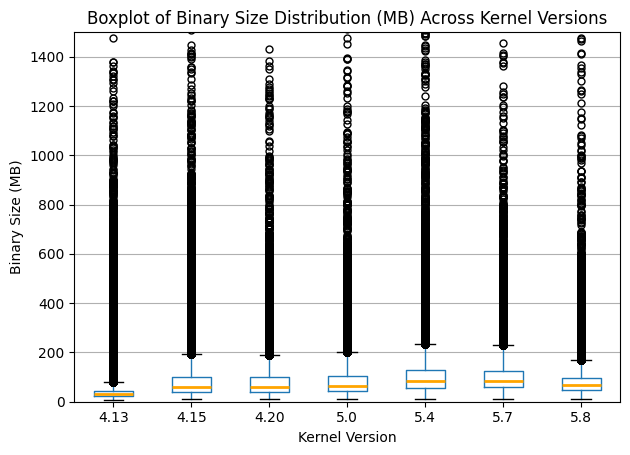

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define paths to the local dataset files and corresponding Linux kernel versions
dataset_info = [
    ("4.13", "dataset_413.pkl"),
    ("4.15", "dataset_415.pkl"),
    ("4.20", "dataset_420.pkl"),
    ("5.0", "dataset_500.pkl"),  
    ("5.4", "dataset_504.pkl"),
    ("5.7", "dataset_507.pkl"),
    ("5.8", "dataset_508.pkl")
]

all_data = []
for version, dataset_path in dataset_info:
    df = pd.read_pickle(dataset_path)

    # Convert 'vmlinux' binary size from bytes to MB
    if "vmlinux" in df.columns:
        df["vmlinux"] = df["vmlinux"] / (1024 * 1024)
        df["Version"] = version
        all_data.append(df[["Version", "vmlinux"]])

combined_df = pd.concat(all_data, ignore_index=True)

plt.figure(figsize=(10, 6))
combined_df.boxplot(by="Version", column=["vmlinux"], grid=False, showfliers=True,
                    flierprops=dict(marker='o', markersize=5, linestyle='none', markeredgecolor='black'),
                    medianprops=dict(color='orange', linewidth=2))

plt.title("Boxplot of Binary Size Distribution (MB) Across Kernel Versions")
plt.suptitle('')  # Remove the automatic subtitle
plt.xlabel("Kernel Version")
plt.ylabel("Binary Size (MB)")
plt.ylim(0, 1500)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("tuxkconfig_boxplot.png", dpi=300)
plt.show()

## Boxplot - OpenML

In [ ]:
import pandas as pd
import openml
import matplotlib.pyplot as plt

# Linux kernel versions with corresponding OpenML dataset IDs
dataset_info = [
    ("4.13", 46759),
    ("4.15", 46739),
    ("4.20", 46740),
    ("5.0", 46741),
    ("5.4", 46742),
    ("5.7", 46743),
    ("5.8", 46744)
]

all_data = []

for version, dataset_id in dataset_info:
    # Load dataset from OpenML
    dataset = openml.datasets.get_dataset(dataset_id)
    df, _, _, _ = dataset.get_data(dataset_format="dataframe")

    # Convert binary size from bytes to MB
    if "vmlinux" in df.columns:
        df["vmlinux"] = df["vmlinux"] / (1024 * 1024)
        df["Version"] = version
        all_data.append(df[["Version", "vmlinux"]])

# Combine all datasets
combined_df = pd.concat(all_data, ignore_index=True)

# Generate boxplot
plt.figure(figsize=(10, 6))
combined_df.boxplot(by="Version", column=["vmlinux"], grid=False, showfliers=True,
                    flierprops=dict(marker='o', markersize=5, linestyle='none', markeredgecolor='black'),
                    medianprops=dict(color='orange', linewidth=2))

# Customize plot
plt.title("Boxplot of Binary Size Distribution (MB) Across Kernel Versions")
plt.suptitle('')  # Remove automatic 'Boxplot grouped by Version' title
plt.xlabel("Kernel Version")
plt.ylabel("Binary Size (MB)")
plt.ylim(0, 1500)
plt.grid(axis='y')
plt.tight_layout()

# Save and display the plot
plt.savefig("tuxkconfig_boxplot.png", dpi=300)
plt.show()


## 4.1 Performance Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# known targets to exclude from training features
known_targets = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "BZIP2-bzImage", "BZIP2-vmlinux", 
                 "LZMA-bzImage", "LZMA-vmlinux", "XZ-vmlinux", "bzImage"]

dataset = pd.read_pickle("dataset_508.pkl")

# Convert vmlinux sizes from bytes to MB 
#dataset["vmlinux"] = dataset["vmlinux"] / (1024 * 1024)

# Separate features (configuration options) and target (vmlinux size in MB)
# Exclude known targets from the features
X = dataset.drop(columns=known_targets, errors="ignore")
y = dataset["vmlinux"]

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Print the MAPE -  [dataset_508 MAPE: 83.44%]
print(f"MAPE: {mape:.2f}%")

## 4.2 Transfer Learning

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
import openml
import pandas as pd
import numpy as np

# The known targets to exclude from training features
drops = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "BZIP2-bzImage", "BZIP2-vmlinux", "LZMA-bzImage", "LZMA-vmlinux", "XZ-vmlinux", "bzImage"]

# TuxKConfig v5.4 and v5.7 (sources), v5.8 (target)
src_504 = openml.datasets.get_dataset(46742)  # v5.4
src_507 = openml.datasets.get_dataset(46743)  # v5.7
trg_508 = openml.datasets.get_dataset(46744)  # v5.8

# Get the data as DataFrames
X_504,_,_,_=src_504.get_data(dataset_format="dataframe")
X_507,_,_,_=src_507.get_data(dataset_format="dataframe")
X_trg,_,_,_=trg_508.get_data(dataset_format="dataframe")
y_504 = X_504["vmlinux"]
y_507 = X_507["vmlinux"]
y_trg = X_trg["vmlinux"]

# Extract features and target 
X_504 = X_504.drop(columns=drops,errors="ignore")
X_507 = X_507.drop(columns=drops,errors="ignore")
X_trg = X_trg.drop(columns=drops,errors="ignore")

# Feature engineering
for df in [X_504, X_507, X_trg]:
    df["nb_yes"] = df.eq(1).sum(axis=1)

# Combine source data from v5.4 and v5.7
X_source = pd.concat([X_504, X_507], axis=0)
y_source = pd.concat([y_504, y_507], axis=0)

# Align features across the source and target datasets
feats = X_source.columns.intersection(X_trg.columns)
X_source = X_source[feats]
X_trg = X_trg[feats]

# Drop rows where y_source or y_target is NaN 
src_df = pd.concat([X_source, y_source], axis=1).dropna()
X_source = src_df.drop(columns=["vmlinux"])
y_source = src_df["vmlinux"]

trg_combined = pd.concat([X_trg, y_trg], axis=1).dropna()
X_trg = trg_combined.drop(columns=["vmlinux"])
y_trg = trg_combined["vmlinux"]

# Train on combined source data and predict on v5.8
model = HistGradientBoostingRegressor(random_state=42)
model.fit(X_source, y_source)
predictions = model.predict(X_trg)

# Calculate MAPE (Mean Absolute Percentage Error) 
mape = np.mean(np.abs((predictions-y_trg)/(y_trg)))*100
print(f"MAPE: {mape:.2f}%")

## 4.3 Interpretability

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import openml
import pandas as pd

# Define known targets to exclude from training features
known_targets = [
    "vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "BZIP2-bzImage", "BZIP2-vmlinux", "LZMA-bzImage", "LZMA-vmlinux", "XZ-vmlinux", "bzImage"]

# TuxKConfig v5.8 (dataset ID: 46744)
dataset = openml.datasets.get_dataset(46744)
X,_,_,_=dataset.get_data(dataset_format="dataframe")
y = X["vmlinux"]

# Remove known target 
X = X.drop(columns=known_targets, errors="ignore")

# Train model for feature importances
model=RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X, y)

# Compute feature importances from the trained model
importances = model.feature_importances_
features = X.columns

# The top 5 most influential configuration options
top_indices = importances.argsort()[-5:][::-1]
top5 =[(features[i],importances[i]) for i in top_indices]

for feature, score in top5:
    print(f"{feature}: {score:.4f}")
    
#DEBUG_INFO: 0.2008
#DEBUG_INFO_REDUCED: 0.1702
#DEBUG_INFO_SPLIT: 0.1261
#active_options: 0.0854
#RANDOMIZE_BASE: 0.0766

## 4.4 Feature selection


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import openml
import pandas as pd
import numpy as np

# Known targets to exclude
known_targets = [
    "vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "BZIP2-bzImage",
    "BZIP2-vmlinux", "LZMA-bzImage", "LZMA-vmlinux", "XZ-vmlinux", "bzImage"
]

# Load data
dataset = openml.datasets.get_dataset(46744)
X, _, _, _ = dataset.get_data(dataset_format="dataframe")
y = X["vmlinux"]
X = X.drop(columns=known_targets, errors="ignore")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomForest for feature selection
selector = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=42))
selector.fit(X_train, y_train)
selected_features = X.columns[selector.get_support()]

# Results of feature selection
print(f"Reduced from {X.shape[1]} to {len(selected_features)} features")
print(f"Sample selected features: {selected_features[:5].tolist()}")

# Evaluate with selected features
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])

# MAPE evaluation
epsilon = 1e-10
mape = np.mean(np.abs((y_test - y_pred) / (y_test + epsilon))) * 100
print(f"MAPE after RandomForest feature selection: {mape:.2f}%")


#Reduced from 11542 to 106 features
#Sample selected features: ['DMA_COHERENT_POOL', 'ARCH_HAS_FORCE_DMA_UNENCRYPTED', 'PM_DEVFREQ', 'EROFS_FS_ZIP', 'BATTERY_GOLDFISH']
#MAPE after RandomForest feature selection: 5.16%
